In [4]:
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio
import sys
import csv


In [5]:
image_path = '/home/niaki/Code/Lenna.png'

patch_size = 16
patch_width = patch_size
patch_height = patch_size

nearest_patches_nb = -1
query_stride = 100
compare_stride = 8
eps = 0.0001


In [6]:
image = imageio.imread(image_path)

# to be deleted
# image = image[:40, :40, :]

image = np.dot(image[ : ,  : , : 3], [0.299, 0.587, 0.114])

image_height = image.shape[0]
image_width = image.shape[1]

if nearest_patches_nb == -1:
    nearest_patches_nb = len(range(0, image_width - patch_size + 1, compare_stride)) * len(range(0, image_height - patch_size + 1, compare_stride))

In [7]:
def patch_diff(patch1, patch2):
    if patch1.shape != patch2.shape:
        print("Patches don't have the same shape.")
        return
    return np.sum((np.array(patch1, dtype=np.float32) - np.array(patch2, dtype=np.float32))**2)

In [9]:
results_patches_diffs = {}
results_patches_x_coords = {}
results_patches_y_coords = {}
results_patches_positions = {}

counter_query_patches = 0

12, 9
122, 168
101, 315
473, 26


x_querys = [9, 58, 315, 26] #[9, 168, 315, 26] 
y_querys = [12, 233, 101, 473] #[12, 122, 101, 473]

total_nr_query_patches = len(x_querys)

for query_it in range(total_nr_query_patches):
    
    x_query = x_querys[query_it]
    y_query = y_querys[query_it]
    
    sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

    query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size]

    counter_compare_patches = 0
    compare_patches_scores = {}

    patches_diffs = [1000000000]
    patches_x_coords = [-1]
    patches_y_coords = [-1]
    patches_positions = [-1]

    for y_compare in range(0, image_width - patch_size + 1, compare_stride):
        for x_compare in range(0, image_height - patch_size + 1, compare_stride):

            compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size]

            diff = patch_diff(query_patch, compare_patch)

            if diff < eps:
                counter_compare_patches += 1
                print('wtf')
                continue

            # sorting
            for i in range(len(patches_diffs)):
                if diff < patches_diffs[i]:
                    patches_diffs.insert(i, diff)
                    patches_x_coords.insert(i, x_compare)
                    patches_y_coords.insert(i, y_compare)
                    patches_positions.insert(i, counter_compare_patches)
                    break

            counter_compare_patches += 1
        
    results_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
    results_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
    results_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
    results_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]

    counter_query_patches += 1

4/4

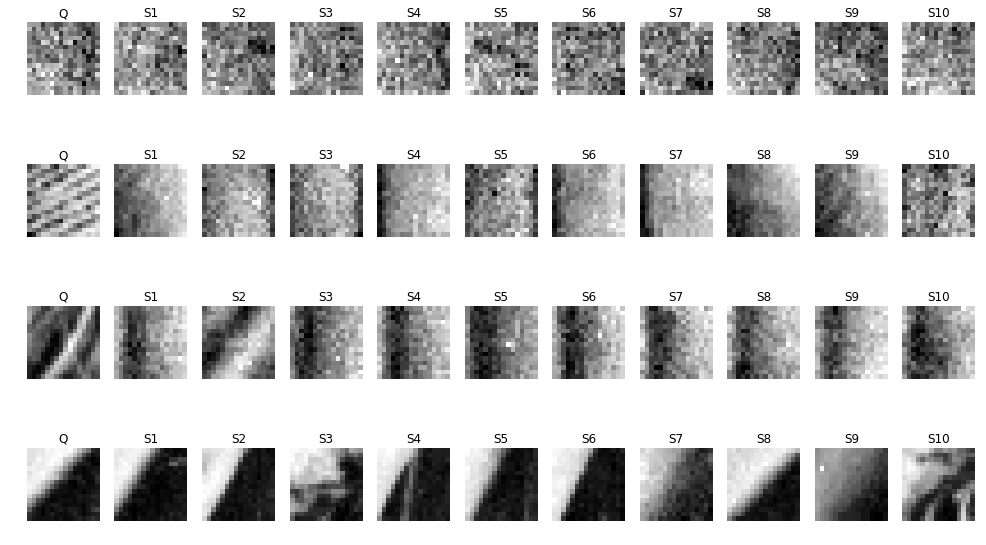

In [10]:
fig = plt.figure(figsize=(17, 10))

nr_similar_patches = 10

columns = nr_similar_patches + 1
rows = total_nr_query_patches

counter_query_patches = 0

x_querys = [9, 58, 315, 26] #[9, 168, 315, 26] 
y_querys = [12, 233, 101, 473] #[12, 122, 101, 473]

total_nr_query_patches = len(x_querys)

for query_it in range(total_nr_query_patches):
    
    x_query = x_querys[query_it]
    y_query = y_querys[query_it]

    ax = fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 1)
    ax.axis('off')
    ax.set_title('Q')
    ax.imshow(image[x_query : x_query + patch_size, y_query : y_query + patch_size], cmap='gray')


    for i in range(nr_similar_patches):
        x_compare = results_patches_x_coords[counter_query_patches][i]
        y_compare = results_patches_y_coords[counter_query_patches][i]

        ax = fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 2 + i)
        ax.axis('off')
        ax.set_title('S' + str(i + 1))
        ax.imshow(image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size], cmap='gray')

    counter_query_patches += 1

In [30]:
temp_noisy_descr = np.zeros((nearest_patches_nb, 4))
temp_noisy_descr[:, 0] = results_patches_x_coords[0]
temp_noisy_descr[:, 1] = results_patches_y_coords[0]
temp_noisy_descr[:, 2] = results_patches_positions[0]
temp_noisy_descr[:, 3] = results_patches_diffs[0]

In [31]:
temp_noisy_descr

array([[8.000000e+00, 3.680000e+02, 2.899000e+03, 2.117600e+04],
       [1.600000e+01, 3.680000e+02, 2.900000e+03, 2.128200e+04],
       [1.600000e+01, 8.000000e+00, 6.500000e+01, 2.133400e+04],
       ...,
       [4.640000e+02, 1.760000e+02, 1.444000e+03, 8.563624e+06],
       [4.800000e+02, 1.680000e+02, 1.383000e+03, 8.651777e+06],
       [4.720000e+02, 1.760000e+02, 1.445000e+03, 8.819750e+06]])

In [8]:
def add_gaussian_noise(image, mean=0, sigma=20):
    """Add Gaussian noise to an image of type np.uint8."""
    gaussian_noise = np.random.normal(mean, sigma, image.shape)
    gaussian_noise = gaussian_noise.reshape(image.shape)
    noisy_image = image + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.astype(np.uint8)
    return noisy_image

In [9]:
image_noisy = add_gaussian_noise(image, sigma=0)

In [11]:
input_size = 16 * 16
hidden_size = 128  # Layer 1 Hidden Size

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
# theta = sae_opt_theta
theta = np.load('/home/niaki/temp/encoderChenEtAl.npy')

W1 = theta[0:hidden_size * input_size].reshape(hidden_size, input_size)
W2 = theta[hidden_size * input_size:2 * hidden_size * input_size].reshape(input_size, hidden_size)
b1 = theta[2 * hidden_size * input_size:2 * hidden_size * input_size + hidden_size]
b2 = theta[2 * hidden_size * input_size + hidden_size:]

In [16]:
np.expand_dims(query_patch.reshape(patch_size * patch_size), axis=1).shape

(256, 1)

In [19]:
results_noisy_descr_patches_diffs = {}
results_noisy_descr_patches_x_coords = {}
results_noisy_descr_patches_y_coords = {}
results_noisy_descr_patches_positions = {}

counter_query_patches = 0

12, 9
122, 168
101, 315
473, 26

compare_stride = 8

x_querys = [9, 58, 315, 26] #[9, 168, 315, 26] 
y_querys = [12, 233, 101, 473] #[12, 122, 101, 473]

total_nr_query_patches = len(x_querys)

for query_it in range(total_nr_query_patches):
    
    x_query = x_querys[query_it]
    y_query = y_querys[query_it]
    
    sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

    query_patch = image_noisy[x_query : x_query + patch_size, y_query : y_query + patch_size]
#     query_patch_descr = encoder.predict(np.expand_dims(query_patch, axis=0))[0]
#         query_patch_descr = np.mean(query_patch)
#     _, query_patch_descr = sift.compute(query_patch, keypoints)

    data = np.expand_dims(query_patch.reshape(patch_size * patch_size), axis=1)
    z2 = W1.dot(data) + np.tile(b1, (1, 1)).transpose()
    query_patch_descr = sigmoid(z2)
    
    
    counter_compare_patches = 0
    compare_patches_scores = {}

    patches_diffs = [1000000000]
    patches_x_coords = [-1]
    patches_y_coords = [-1]
    patches_positions = [-1]

    for y_compare in range(0, image_width - patch_size + 1, compare_stride):
        for x_compare in range(0, image_height - patch_size + 1, compare_stride):

            compare_patch = image_noisy[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size]
#             compare_patch_descr = encoder.predict(np.expand_dims(compare_patch, axis=0))[0]
#                 compare_patch_descr = np.mean(compare_patch)
#             _, compare_patch_descr = sift.compute(compare_patch, keypoints)

            data = np.expand_dims(compare_patch.reshape(patch_size * patch_size), axis=1)
            z2 = W1.dot(data) + np.tile(b1, (1, 1)).transpose()
            compare_patch_descr = sigmoid(z2)


            diff = patch_diff(query_patch_descr, compare_patch_descr)
#                 diff = (query_patch_descr - compare_patch_descr)**2

            if diff < eps:
                counter_compare_patches += 1
                continue

            # sorting
            for i in range(len(patches_diffs)):
                if diff < patches_diffs[i]:
                    patches_diffs.insert(i, diff)
                    patches_x_coords.insert(i, x_compare)
                    patches_y_coords.insert(i, y_compare)
                    patches_positions.insert(i, counter_compare_patches)
                    break

            counter_compare_patches += 1

    results_noisy_descr_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
    results_noisy_descr_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
    results_noisy_descr_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
    results_noisy_descr_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]

    counter_query_patches += 1

1/4

/home/niaki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


4/4

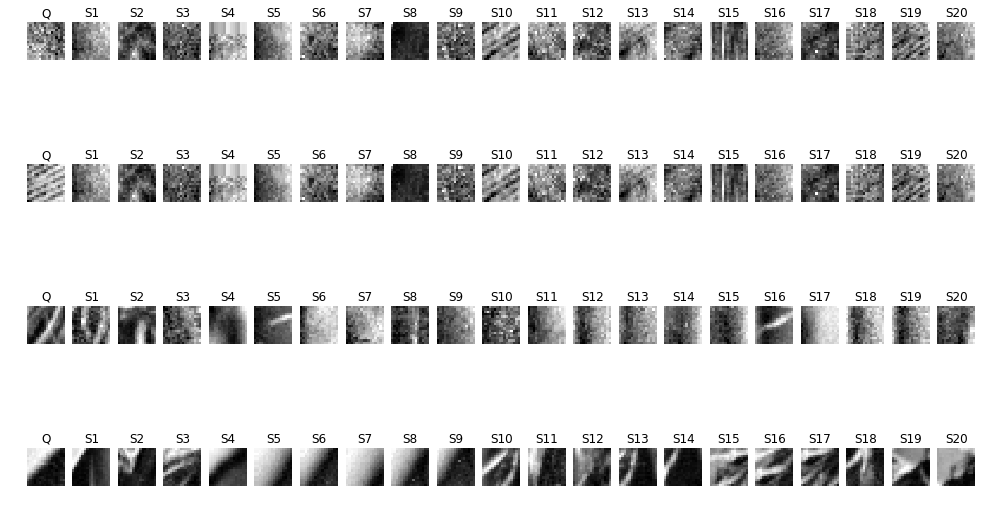

In [21]:
# 4.1 noise 0
fig = plt.figure(figsize=(17, 10))

nr_similar_patches = 20

columns = nr_similar_patches + 1
rows = total_nr_query_patches

counter_query_patches = 0

x_querys = [9, 58, 315, 26] #[9, 168, 315, 26] 
y_querys = [12, 233, 101, 473] #[12, 122, 101, 473]

total_nr_query_patches = len(x_querys)

for query_it in range(total_nr_query_patches):
    
    x_query = x_querys[query_it]
    y_query = y_querys[query_it]

    ax = fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 1)
    ax.axis('off')
    ax.set_title('Q')
    ax.imshow(image[x_query : x_query + patch_size, y_query : y_query + patch_size], cmap='gray')

    for i in range(nr_similar_patches):
        x_compare = results_noisy_descr_patches_x_coords[counter_query_patches][i]
        y_compare = results_noisy_descr_patches_y_coords[counter_query_patches][i]

        ax = fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 2 + i)
        ax.axis('off')
        ax.set_title('S' + str(i + 1))
        ax.imshow(image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size], cmap='gray')

    counter_query_patches += 1

In [34]:
temp_noisy_descr = np.zeros((nearest_patches_nb, 4))
temp_noisy_descr[:, 0] = results_noisy_descr_patches_x_coords[2]
temp_noisy_descr[:, 1] = results_noisy_descr_patches_y_coords[2]
temp_noisy_descr[:, 2] = results_noisy_descr_patches_positions[2]
temp_noisy_descr[:, 3] = results_noisy_descr_patches_diffs[2]

In [35]:
temp_noisy_descr

array([[  272.        ,   136.        ,  1105.        ,  1505.59521484],
       [  280.        ,   152.        ,  1232.        ,  2051.37841797],
       [  432.        ,   144.        ,  1188.        ,  2570.59277344],
       ...,
       [  376.        ,   440.        ,  3512.        , 68581.4375    ],
       [  408.        ,   344.        ,  2760.        , 68589.8828125 ],
       [  224.        ,   112.        ,   910.        , 68605.140625  ]])

In [ ]:
# saving patches to numpy files

In [20]:
dir_saving = '/home/niaki/Downloads'

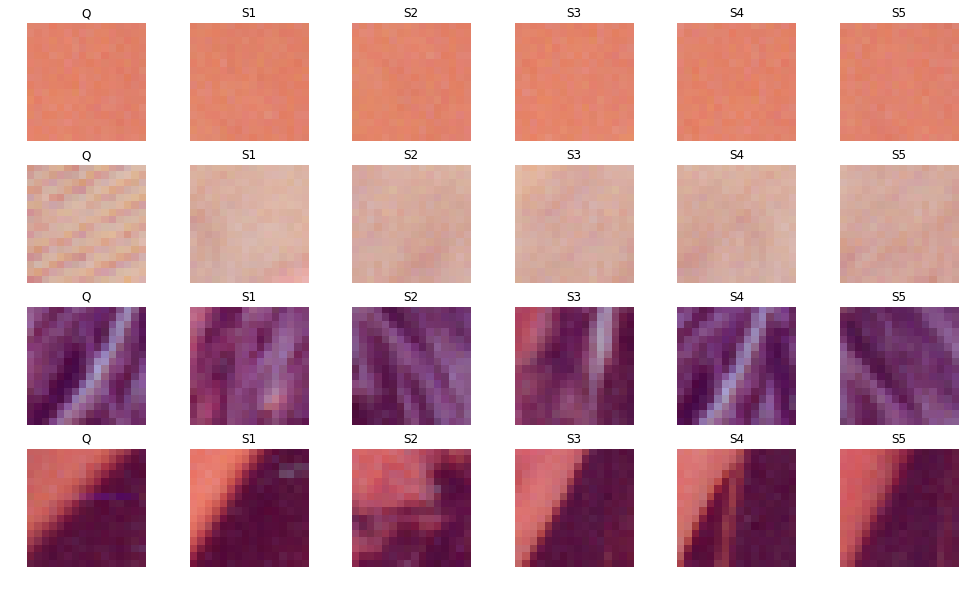

In [23]:
fig = plt.figure(figsize=(17, 10))

nr_similar_patches = 5

columns = nr_similar_patches + 1
rows = total_nr_query_patches

counter_query_patches = 0

x_querys = [9, 58, 315, 26] #[9, 168, 315, 26] 
y_querys = [12, 233, 101, 473] #[12, 122, 101, 473]

total_nr_query_patches = len(x_querys)

for query_it in range(total_nr_query_patches):
    
    x_query = x_querys[query_it]
    y_query = y_querys[query_it]

    ax = fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 1)
    ax.axis('off')
    ax.set_title('Q')
    np.save(dir_saving + '/comparison_query_' + str(query_it), image[x_query : x_query + patch_size, y_query : y_query + patch_size, :])
    ax.imshow(image[x_query : x_query + patch_size, y_query : y_query + patch_size, :])


    for i in range(nr_similar_patches):
        x_compare = results_patches_x_coords[counter_query_patches][i]
        y_compare = results_patches_y_coords[counter_query_patches][i]

        ax = fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 2 + i)
        ax.axis('off')
        ax.set_title('S' + str(i + 1))
        np.save(dir_saving + '/comparison_similar_clean_' + str(query_it) + '_' + str(i + 1), image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :])
        ax.imshow(image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :])

    counter_query_patches += 1

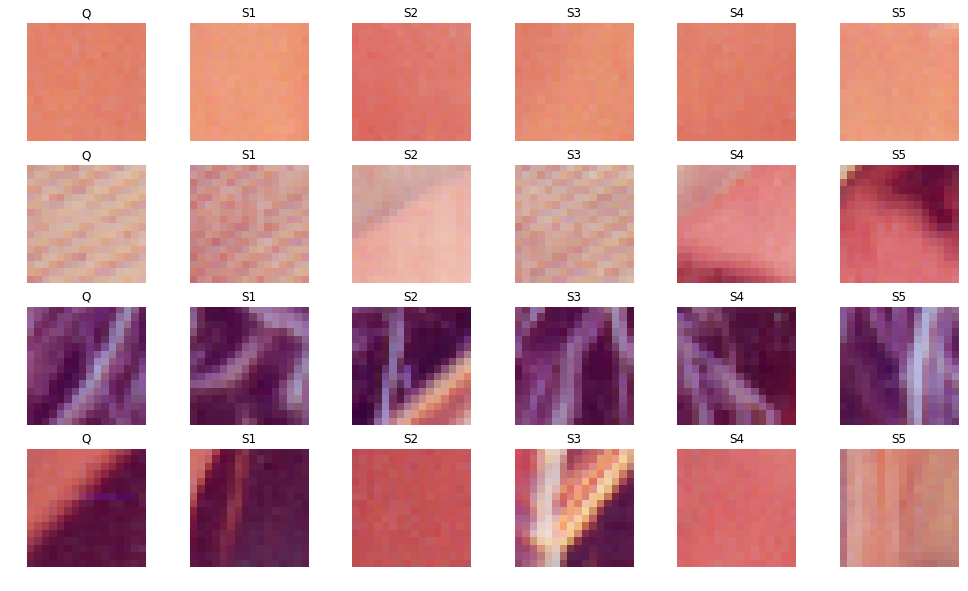

In [28]:
# 4.1
fig = plt.figure(figsize=(17, 10))

nr_similar_patches = 5

columns = nr_similar_patches + 1
rows = total_nr_query_patches

counter_query_patches = 0

x_querys = [9, 58, 315, 26] #[9, 168, 315, 26] 
y_querys = [12, 233, 101, 473] #[12, 122, 101, 473]

total_nr_query_patches = len(x_querys)

for query_it in range(total_nr_query_patches):
    
    x_query = x_querys[query_it]
    y_query = y_querys[query_it]

    ax = fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 1)
    ax.axis('off')
    ax.set_title('Q')
    ax.imshow(image[x_query : x_query + patch_size, y_query : y_query + patch_size, :])

    for i in range(nr_similar_patches):
        x_compare = results_noisy_descr_patches_x_coords[counter_query_patches][i]
        y_compare = results_noisy_descr_patches_y_coords[counter_query_patches][i]

        ax = fig.add_subplot(rows, columns, counter_query_patches * (nr_similar_patches + 1) + 2 + i)
        ax.axis('off')
        ax.set_title('S' + str(i + 1))
        np.save(dir_saving + '/comparison_similar_desc_nina_' + str(query_it) + '_' + str(i + 1), image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :])
        ax.imshow(image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :])

    counter_query_patches += 1

In [ ]:
# saving just the location

In [28]:
nr_similar_patches = 5

counter_query_patches = 0

x_querys = [9, 58, 315, 26] #[9, 168, 315, 26] 
y_querys = [12, 233, 101, 473] #[12, 122, 101, 473]

total_nr_query_patches = len(x_querys)

for query_it in range(total_nr_query_patches):
    
    x_query = x_querys[query_it]
    y_query = y_querys[query_it]

    print(str(x_query) + ' ' + str(y_query) + "     "),

    for i in range(nr_similar_patches):
        x_compare = results_patches_x_coords[counter_query_patches][i]
        y_compare = results_patches_y_coords[counter_query_patches][i]
        
        print(str(x_compare) + ' ' + str(y_compare) + "   "),
        
    counter_query_patches += 1
    print('')

9 12      136 488    176 472    184 480    200 488    176 480    
58 233      424 312    272 40    280 40    488 40    352 40    
315 101      192 64    464 464    64 64    200 64    136 64    
26 473      88 424    344 320    216 168    360 312    312 336    


In [37]:
nr_similar_patches = 20

counter_query_patches = 0

x_querys = [9, 58, 315, 26] #[9, 168, 315, 26] 
y_querys = [12, 233, 101, 473] #[12, 122, 101, 473]

total_nr_query_patches = len(x_querys)

for query_it in range(total_nr_query_patches):
    
    x_query = x_querys[query_it]
    y_query = y_querys[query_it]

    print(x_query, y_query)

    # x
    for i in range(nr_similar_patches):
        x_compare = results_noisy_descr_patches_x_coords[counter_query_patches][i]
        
        print(str(x_compare) + ","),
    
    print('')
    
    for i in range(nr_similar_patches):
        y_compare = results_noisy_descr_patches_y_coords[counter_query_patches][i]
        
        print(str(y_compare) + ","),
    
    counter_query_patches += 1
    print('')

(9, 12)
432, 200, 184, 184, 192, 448, 0, 456, 200, 280, 440, 16, 184, 176, 176, 8, 264, 464, 464, 352, 
192, 480, 456, 0, 472, 264, 360, 264, 472, 168, 384, 392, 464, 456, 472, 360, 0, 264, 272, 408, 
(58, 233)
128, 160, 64, 56, 56, 496, 224, 232, 72, 120, 8, 112, 48, 80, 352, 72, 80, 288, 272, 104, 
80, 88, 240, 224, 232, 216, 80, 176, 200, 232, 456, 240, 184, 208, 136, 192, 80, 72, 120, 248, 
(315, 101)
344, 216, 304, 240, 336, 312, 304, 416, 136, 232, 192, 264, 456, 432, 208, 424, 224, 344, 432, 232, 
72, 400, 88, 208, 72, 96, 104, 80, 432, 160, 224, 136, 224, 432, 400, 488, 264, 328, 488, 192, 
(26, 473)
16, 24, 32, 8, 40, 392, 184, 472, 192, 384, 32, 48, 64, 24, 8, 16, 40, 200, 264, 360, 
480, 472, 464, 488, 456, 472, 384, 432, 376, 480, 472, 456, 440, 480, 496, 488, 464, 368, 224, 160, 
